In [1]:
import s3fs
import nibabel as nib
from nibabel.affines import rescale_affine
import pandas as pd 
import matplotlib.pyplot as plt 
from skimage.transform import rescale
from skimage.filters import gaussian
from nilearn import plotting 
import numpy as np

In [2]:
fs = s3fs.S3FileSystem(anon=True)

In [14]:
#ll = fs.ls('natural-scenes-dataset/nsddata_betas/ppdata/subj01/MNI/betas_fithrf/betas_session0.nii.gz')
#mask = fs.ls('natural-scenes-dataset/nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz')

In [ ]:
#ll

In [44]:

#for fname in ll: 
    #fs.get(fname, "tmp.nii.gz")
    #img = nib.load("tmp.nii.gz")

    # XXX do something with one file
#fs.get(ll[0], "tmp.nii.gz")
#fs.get(mask[0], "brainmask.nii.gz")

img = nib.load("tmp.nii.gz")
#img_data = img.get_fdata()
beta_trial = img.slicer[:,:,:,1].get_fdata()/300 #get trial 1

#brainmask_img = nib.load("brainmask.nii.gz")
#brainmask = brainmask_img.get_fdata()
#header = img.header

#smooth
img_smoothed = gaussian(beta_trial, sigma=4)

#downsample 
img_rescaled = rescale(img_smoothed, 0.25, anti_aliasing=False)

rescaled_affine = rescale_affine(img.affine, shape = beta_trial.shape, zooms = (4, 4, 4), new_shape = img_rescaled.shape)

#flattening 
flat_img = img_rescaled.flatten()

#sigma = 8 #the higher the smoother, will smooth less when we have time, for now at 8 for neurohack presentation timeline 
#fhwm = nibabel.processing.sigma2fwhm(sigma) 
#smoothed_img = nibabel.processing.smooth_image(down_img, fhwm) 

#affine nibabel documentation 

    # Append into total results:
    # results.append(XXX)

In [26]:
beta_trial.shape

(182, 218, 182)

In [27]:
img_smoothed.shape

(182, 218, 182)

In [43]:
img_rescaled.shape

(46, 54, 46)

In [45]:
flat_img.shape

(114264,)

In [3]:
subject = 3
trials_info = pd.read_csv('../annotation_data/shared_trial_info.csv')
trials_sub = trials_info[((trials_info.SUBJECT == subject))]
trials_sub.head()
len(trials_sub)

2371

In [4]:
# 1.8 mm space functional data
# subj 1, session 1 
#trials = trials_sub1['trial_in_session'].tolist()
#sessions = [1] #For veronica testing
sessions = trials_sub.SESSION.unique() #to loop over all sessions

#beta_trials = []
#np.asarray(beta_trials)
for session in sessions:
    if (session < 10):
        ll = fs.ls(f'natural-scenes-dataset/nsddata_betas/ppdata/subj0{subject}/MNI/betas_fithrf/betas_session0{session}.nii.gz')
    else: 
        ll = fs.ls(f'natural-scenes-dataset/nsddata_betas/ppdata/subj0{subject}/MNI/betas_fithrf/betas_session{session}.nii.gz')
    fs.get(ll[0], "tmp.nii.gz")   
    img = nib.load("tmp.nii.gz")
    trials_sub_ses = trials_sub[(trials_sub.SESSION == session)]
    print("file loaded")
    
    for count, t in enumerate(trials_sub_ses['trial_in_session'].tolist()):
        beta_trial = img.slicer[:,:,:,t].get_fdata()/300 #get trial 1
                    
        #smooth
        img_smoothed = gaussian(beta_trial, sigma=4)

        #downsample 
        img_rescaled = rescale(img_smoothed, 0.25, anti_aliasing=False)

        rescaled_affine = rescale_affine(img.affine, shape = beta_trial.shape, zooms = (4, 4, 4), new_shape = img_rescaled.shape)

        #flattening 
        flat_img = img_rescaled.flatten()
        
        if (count ==0):
            ses_betas = flat_img
        else:
            ses_betas = np.vstack((ses_betas, flat_img))
        print(f"ran trial {t} for session {session}")
    #save to np array 
    fname = f"./derivatives/subj{subject}_ses{session}.npy"
    np.save(fname, ses_betas)
    print(f"saved file for session {session}")
    #if (session == 1):
        #beta_trials.to_csv('betas_sub1.csv', index=False)
    #else:
        #beta_trials.to_csv('betas_sub1.csv', index=False, mode="a")
            #beta_trial = beta_trial[:,:,:,np.newaxis]
            #beta_trial = beta_trial[:,:,:,t]
            #beta_trials = np.append(beta_trials, beta_trial,axis=3)
    

NameError: name 'trials_sub1' is not defined

In [ ]:
print("session 1 beta, data shape:", beta_trials.shape)

In [ ]:
#beta_trials.to_csv('betas_sub1_ses1.csv', index=False)

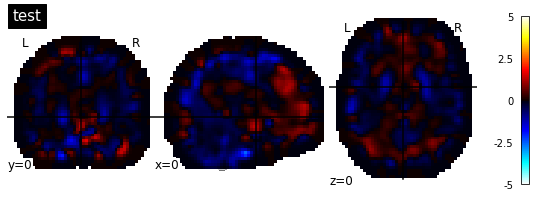

In [42]:
# overlay beta map with brain mask
plotting.plot_stat_map(nib.Nifti1Image(img_rescaled, rescaled_affine), # this function needs a 3D data file
                       #bg_img=nib.Nifti1Image(brainmask, brainmask_img.affine), # load the brain mask as a background picture
                       cut_coords=(0, 0, 0), #use to select coordinates that you want to view
                       title="test",
                       vmax=5)

In [40]:
rescaled_affine

array([[   4.,    0.,    0.,  -89.],
       [   0.,    4.,    0., -122.],
       [   0.,    0.,    4.,  -70.],
       [   0.,    0.,    0.,    1.]])

In [50]:
len(ses_betas)

62